In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer
data = pd.read_csv('./data/LBNL_file.csv', low_memory=False)

df = data.replace([-9999, '-9999', -9999.0], np.nan)
pd.options.display.max_columns = None


In [2]:
df.columns

Index(['data_provider_1', 'data_provider_2', 'system_ID_1', 'system_ID_2',
       'installation_date', 'system_size_DC', 'total_installed_price',
       'rebate_or_grant', 'customer_segment', 'expansion_system',
       'multiple_phase_system', 'new_construction', 'tracking',
       'ground_mounted', 'zip_code', 'city', 'state',
       'utility_service_territory', 'third_party_owned', 'installer_name',
       'self_installed', 'azimuth_1', 'azimuth_2', 'azimuth_3', 'tilt_1',
       'tilt_2', 'tilt_3', 'module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'module_manufacturer_2', 'module_model_2',
       'module_quantity_2', 'module_manufacturer_3', 'module_model_3',
       'module_quantity_3', 'additional_modules', 'technology_module_1',
       'technology_module_2', 'technology_module_3', 'BIPV_module_1',
       'BIPV_module_2', 'BIPV_module_3', 'bifacial_module_1',
       'bifacial_module_2', 'bifacial_module_3', 'nameplate_capacity_module_1',
       'nameplate_capaci

In [3]:
import seaborn as sns


d = df.copy()



# vain california
d = d[d['state'] == "CA"]



In [4]:
# Inverterin koko laskettuna inverter loading ration perusteella
d['inverter_total_capacity'] = d['system_size_DC'] /  d['inverter_loading_ratio']


# paneelien yhteenlaskettu määrä
d['module_quantity'] = d[['module_quantity_1','module_quantity_2','module_quantity_3']].sum(axis=1)

# paneelien hyötysuhteen keskiarvo
d['module_efficiency'] = d[['efficiency_module_1', 'efficiency_module_2',
       'efficiency_module_3']].mean(axis=1)


# Jos systeemissä on mikro-inverttereitä
d['micro_inverter'] = d[['micro_inverter_1', 'micro_inverter_2','micro_inverter_3']].sum(axis=1)
d.loc[d['micro_inverter'] > 0, 'micro_inverter'] = 1
d.loc[d[['micro_inverter_1', 'micro_inverter_2', 'micro_inverter_3']].isnull().all(axis=1),'micro_inverter']=np.nan


# Jos systeemissä on solar_storage_hybrid_inverter
d['solar_storage_hybrid_inverter'] = d[['solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3',]].sum(axis=1)
d.loc[d['solar_storage_hybrid_inverter'] > 0, 'solar_storage_hybrid_inverter'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3']].isnull().all(1),'solar_storage_hybrid_inverter']=np.nan


# Jos systeemissä on built_in_meter_inverter
d['built_in_meter_inverter'] = d[['built_in_meter_inverter_1', 'built_in_meter_inverter_2','built_in_meter_inverter_3']].sum(axis=1)
d.loc[d['built_in_meter_inverter'] > 0, 'built_in_meter_inverter'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['built_in_meter_inverter_1', 'built_in_meter_inverter_2', 'built_in_meter_inverter_3']].isnull().all(axis=1),'built_in_meter_inverter']=np.nan


# Jos systeemissä on 'BIPV_module',
d['BIPV_module'] = d[['BIPV_module_1', 'BIPV_module_2', 'BIPV_module_3']].sum(axis=1)
d.loc[d['BIPV_module'] > 0, 'BIPV_module'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['BIPV_module_1','BIPV_module_2', 'BIPV_module_3']].isnull().all(axis=1),'BIPV_module']=np.nan

# Jos systeemissä on 'bifacial_module',
d['bifacial_module'] = d[['bifacial_module_1', 'bifacial_module_2', 'bifacial_module_3']].sum(axis=1)
d.loc[d['bifacial_module'] > 0, 'bifacial_module'] = 1
# jos kaikki kolme saraketta nan
d.loc[d[['bifacial_module_1','bifacial_module_2', 'bifacial_module_3']].isnull().all(axis=1),'bifacial_module']=np.nan
  
    
# nimellistehojen keskiarvo
d['nameplate_capacity'] = d[['nameplate_capacity_module_1',
       'nameplate_capacity_module_2', 'nameplate_capacity_module_3']].mean(axis=1)


# Invertterien määrä yhteensä
d['inverter_quantity'] = d[['inverter_quantity_1', 'inverter_quantity_2','inverter_quantity_3']].sum(axis=1)
# jos kaikki kolme saraketta nan
d.loc[d[['inverter_quantity_1', 'inverter_quantity_2','inverter_quantity_3']].isnull().all(axis=1),'inverter_quantity']=np.nan


# tilt-keskiarvo
d['tilt'] = d[['tilt_1','tilt_2', 'tilt_3']].mean(axis=1)

# suuntaus
d['azimuth'] = d['azimuth_1']

# residentail = 1, non-residental = 0
d['residential'] = np.where(d['customer_segment'] == "RES", 1, 0)



In [5]:
d.drop(columns=['data_provider_1', 'data_provider_2', 'system_ID_1', 'system_ID_2','module_manufacturer_1', 'module_model_1',
       'module_quantity_1', 'module_manufacturer_2', 'module_model_2',
       'module_quantity_2', 'module_manufacturer_3', 'module_model_3',
       'module_quantity_3', 'additional_modules','azimuth_1', 'azimuth_2', 'azimuth_3', 'tilt_1',
       'tilt_2', 'tilt_3','BIPV_module_1',
       'BIPV_module_2', 'BIPV_module_3', 'BIPV_module','bifacial_module_1',
       'bifacial_module_2', 'bifacial_module_3', 'bifacial_module','inverter_manufacturer_1', 'inverter_model_1',
       'inverter_quantity_1', 'inverter_manufacturer_2', 'inverter_model_2',
       'inverter_quantity_2', 'inverter_manufacturer_3', 'inverter_model_3',
       'inverter_quantity_3', 'additional_inverters', 'micro_inverter_1',
       'micro_inverter_2','micro_inverter_2','micro_inverter_3', 'efficiency_module_1', 'efficiency_module_2',
       'efficiency_module_3',
        'solar_storage_hybrid_inverter_1','solar_storage_hybrid_inverter_2', 'solar_storage_hybrid_inverter_3', 'built_in_meter_inverter_1', 'built_in_meter_inverter_2',
       'built_in_meter_inverter_3','output_capacity_inverter_1',
       'output_capacity_inverter_2', 'output_capacity_inverter_3', 'nameplate_capacity_module_1',
       'nameplate_capacity_module_2', 'nameplate_capacity_module_3', 'customer_segment'], inplace=True)





In [6]:
# kaikki nan
d.drop(columns=['technology_module_3'], inplace=True)

In [7]:
d.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 998971 entries, 105 to 999075
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   installation_date              998971 non-null  object 
 1   system_size_DC                 987664 non-null  float64
 2   total_installed_price          813366 non-null  float64
 3   rebate_or_grant                953631 non-null  float64
 4   expansion_system               998971 non-null  int64  
 5   multiple_phase_system          998971 non-null  int64  
 6   new_construction               207044 non-null  float64
 7   tracking                       899359 non-null  float64
 8   ground_mounted                 759359 non-null  float64
 9   zip_code                       998971 non-null  object 
 10  city                           998971 non-null  object 
 11  state                          998971 non-null  object 
 12  utility_service_territory   

<AxesSubplot:>

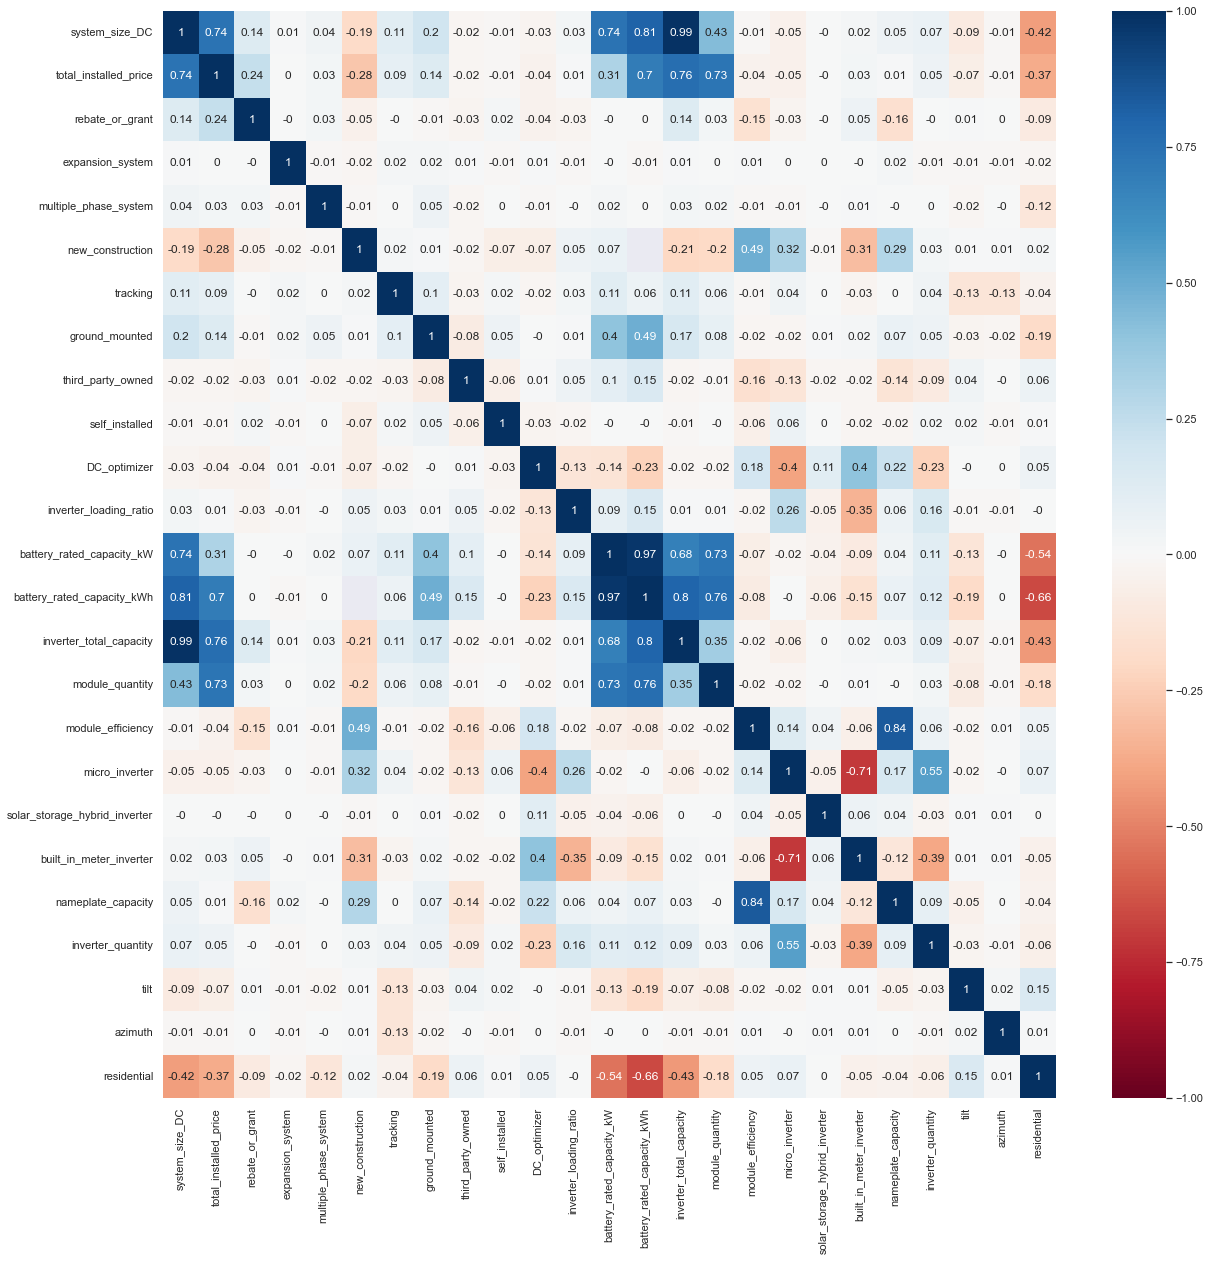

In [8]:
sns.set(rc={'figure.figsize':(20,20)})
corr = d.corr()
corr = corr.round(2)
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)

In [9]:
df2 = d.copy()


res = df2[df2['residential'] == 1]
non_res = df2[df2['residential'] == 0]

#res_price_per_kw = res['total_installed_price'] / res['system_size_DC']
#res_avg_price_per_kw = res_price_per_kw.mean()
#res['total_installed_price'].fillna(round(res_avg_price_per_kw * res['system_size_DC'], 2) , inplace=True)


non_res.info()

res.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 25610 entries, 118 to 999064
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   installation_date              25610 non-null  object 
 1   system_size_DC                 25098 non-null  float64
 2   total_installed_price          19602 non-null  float64
 3   rebate_or_grant                22520 non-null  float64
 4   expansion_system               25610 non-null  int64  
 5   multiple_phase_system          25610 non-null  int64  
 6   new_construction               289 non-null    float64
 7   tracking                       21592 non-null  float64
 8   ground_mounted                 17410 non-null  float64
 9   zip_code                       25610 non-null  object 
 10  city                           25610 non-null  object 
 11  state                          25610 non-null  object 
 12  utility_service_territory      25610 non-nu

In [10]:

# vain rivit jossa invertterin koko
res_inv = res[res['inverter_total_capacity'].notna()]

# vain numeeriset sarakkeet
res_inv.drop(columns=['installation_date','residential', 'zip_code', 'city',
       'state', 'utility_service_territory', 'technology_module_1',
       'technology_module_2','installer_name'], inplace=True)

/var/folders/v9/x83n0f_53h71fc6cqwddq4rr0000gn/T/ipykernel_4283/1969794168.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_inv.drop(columns=['installation_date','residential', 'zip_code', 'city',


In [11]:
res_inv.dropna(axis=1,inplace=True)
res_inv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737584 entries, 106 to 999075
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   system_size_DC           737584 non-null  float64
 1   expansion_system         737584 non-null  int64  
 2   multiple_phase_system    737584 non-null  int64  
 3   DC_optimizer             737584 non-null  float64
 4   inverter_loading_ratio   737584 non-null  float64
 5   inverter_total_capacity  737584 non-null  float64
 6   module_quantity          737584 non-null  float64
 7   micro_inverter           737584 non-null  float64
 8   inverter_quantity        737584 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 56.3 MB


/var/folders/v9/x83n0f_53h71fc6cqwddq4rr0000gn/T/ipykernel_4283/1166029127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_inv.dropna(axis=1,inplace=True)


In [12]:
>>> import numpy as np
>>> from sklearn.model_selection import train_test_split

y = res_inv['inverter_total_capacity']
X = res_inv.drop(['inverter_total_capacity'], axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [13]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaler.fit(X_train)

#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

In [14]:
print(len(X), len(X_train), len(X_test))

from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=2)
regressor.fit(X_train, y_train)

737584 590067 147517


KNeighborsRegressor(n_neighbors=2)

In [15]:
y_pred = regressor.predict(X_test)

In [16]:
regressor.score(X_test, y_test)

0.8869409323256656

In [17]:
e = pd.DataFrame(columns=['size', 'prediction', 'actual'])

e['size'] = X_test['system_size_DC']
e['prediction'] = y_pred
e['actual'] = y_test
e['difference_p'] = round(abs(1- e['prediction'] / e['actual']), 3)
e['difference'] = e['prediction'] - e['actual']

In [18]:
e

,size,prediction,actual,difference_p,difference
570560,6.370000,5.590,5.590,0.0,0.0
122709,3.100000,3.747,3.747,0.0,0.0
945108,3.100000,3.000,3.000,0.0,0.0
494624,4.084163,3.360,3.360,0.0,0.0
384678,10.800000,10.000,10.000,0.0,0.0
...,...,...,...,...,...
363806,2.650000,3.000,3.000,0.0,0.0
949818,6.502041,5.590,5.590,0.0,0.0
762786,8.280000,7.700,7.700,0.0,0.0
264683,8.370000,7.600,7.600,0.0,0.0


0.004118901550329681


,size,prediction,actual,difference_p,difference
count,147517.000000,147517.000000,147517.000000,147517.000000,147517.000000
mean,6.204405,5.570135,5.571900,0.004119,-0.001765
std,5.000288,4.242327,4.589888,0.145406,1.543315
min,0.215000,0.215000,0.215000,0.000000,-309.955000
25%,4.020000,3.655000,3.655000,0.000000,0.000000
50%,5.565000,5.000000,5.000000,0.000000,0.000000
75%,7.590000,7.000000,7.000000,0.000000,0.000000
max,1106.560000,738.845000,1048.800000,55.061000,468.295000


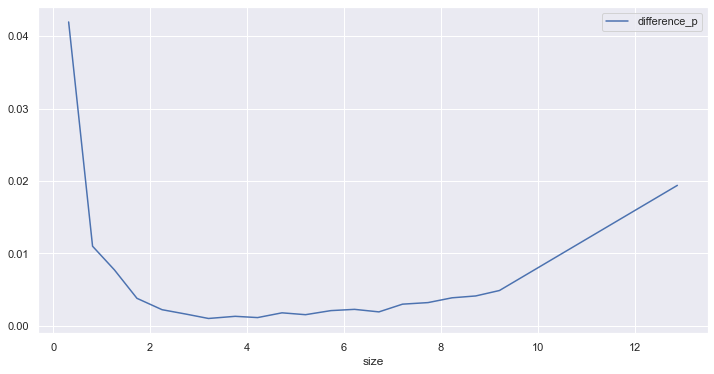

In [19]:
pd.options.display.max_rows = 500


a = e.copy()

a.sort_values('size', inplace=True)
bins =  np.arange(0, 10, 0.5)
ind = np.digitize(a['size'], bins)
    
b = a.groupby(ind).mean()
print(e['difference_p'].mean())
#x = e.drop(columns=['actual', 'prediction'])
e.sort_values('size', inplace=True)
b.plot(x='size', y='difference_p',kind='line', figsize=(12,6))
e.describe()